In [94]:
import torch
import torchvision.transforms as transforms
from pathlib import Path
from  PIL import Image
import matplotlib.pyplot as plt
import random

from tables.flavor import toarray

torch.__version__

'2.9.1+cu130'

# Creating a path to dataset.

The cell below this one will create a path to the images for you. It will also set up the rest of the notebook to work on your hardware. If it outputs 'cuda' then you will most likly have a fast experience. if it outputs 'cpu' you may have a slow experience.

In [95]:
sorted_set = Path("sorted")

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

device

'cuda'

Lets preview an image using matplotlib

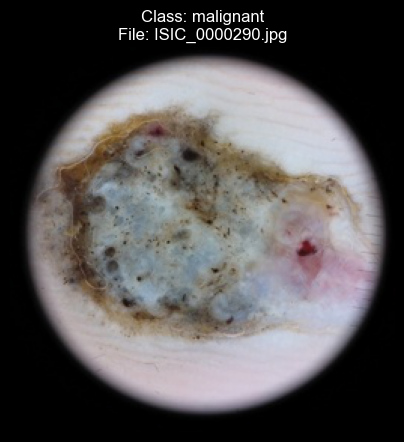

In [96]:
random.seed(42)

# Display a random image from the sorted dataset
def show_random_image(path):
    # Find all jpg images recursively inside the path
    images = list(path.rglob("*.jpg"))

    if not images:
        print(f"No images found in {path}")
        return

    random_image = random.choice(images)
    img = Image.open(random_image)

    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.title(f"Class: {random_image.parent.name}\nFile: {random_image.name}")
    plt.axis("off")
    plt.show()

show_random_image(sorted_set)

Great! The images are able to load from the dataset! If we want our model to be able to make predictions based on them, we have to resize them though.

In [97]:
#resize the images
img_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor()
])

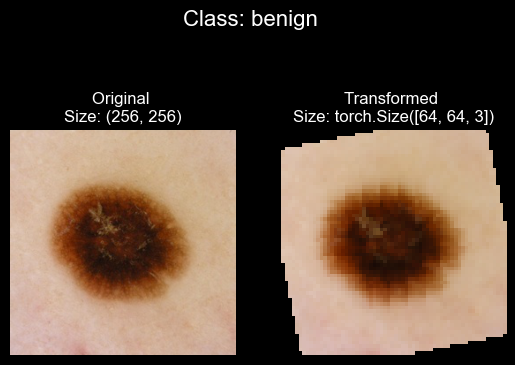

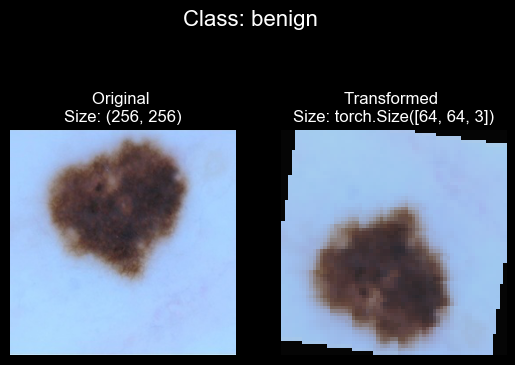

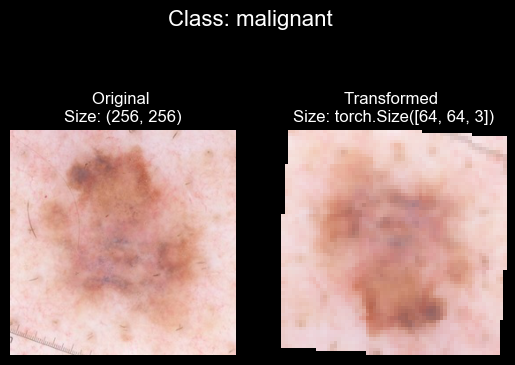

In [98]:
#Plot the resized images using matplotlib
def plot_transformed_images(image_paths, transform, n=3):
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.name}", fontsize=16)
            plt.show()


image_path_list = list(sorted_set.rglob("*.jpg"))

plot_transformed_images(image_path_list,
                        transform=img_transform,
                        n=3)

Nice! we are able to resize the chunky 224x224 images into manageable 64x64 images.

The reason the images are moved around is to make sure the model doesn't memorize images.

In the next cell, you will see how to make a dataset and split it into 2 subsets.

In [99]:
from torch.utils.data import random_split, DataLoader
from torchvision import datasets

dataset_unsplit =datasets.ImageFolder(
    root=sorted_set,
    # transform=img_transform
    transform=img_transform
)

train_set, test_set = random_split(dataset_unsplit, [0.8, 0.2])

Now that we have datasets, we need dataloaders to train our model. The batch size it the amount of images to run per epoch, num_workers is the cpu cores to use to transfer files, and shuffle is if images are moved around randomly in the set.

In [100]:
train_loader = DataLoader(train_set,
                          batch_size=1024,
                          num_workers=0,
                          shuffle=True)
test_loader = DataLoader(test_set,
                         batch_size=10,
                         num_workers=0,
                         shuffle=False)

In [101]:
#Create the model with torch.nn
import torch.nn as nn
import torch.nn.functional as F

class GUPPYmyelomaV1(nn.Module):
    def __init__(self, hidden_units: int = 16, dropout_p: float = 0.5):
        super().__init__()
        self.features = nn.Sequential(
            # 64x64 -> 32x32
            nn.Conv2d(3, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # 32x32 -> 16x16
            nn.Conv2d(hidden_units, hidden_units * 2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            # 16x16 -> 8x8
            nn.Conv2d(hidden_units * 2, hidden_units * 2, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=dropout_p),
            nn.Linear((hidden_units * 2) * 8 * 8, 1),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x.squeeze(-1)

In [102]:
#make the loss
class BinaryFocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction="mean"):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

Make the model

In [103]:
hidden_units = 10
model = GUPPYmyelomaV1(hidden_units=hidden_units).to(device)
criterion = BinaryFocalLoss(alpha=0.75, gamma=2.0)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

# WAIT
before running the next cell, skip it and run the one after if you don't want to train a new model

If you really want to run it, press ```ctrl+a``` and then ```ctrl+/(slash)```

In [104]:
# import torch
# import os
#
# os.makedirs("checkpoints", exist_ok=True)
#
# # --- config ---
# num_epochs      = 50
# train_threshold = 0.3
# eval_threshold  = 0.3
#
# patience        = 7
# best_val_loss   = float("inf")
# epochs_no_improve = 0
# best_state      = None
#
# for epoch in range(num_epochs):
#     # ---------- TRAIN ----------
#     model.train()
#     running_loss = 0.0
#     correct = 0
#     total = 0
#
#     for inputs, targets in train_loader:
#         inputs  = inputs.to(device)
#         targets = targets.to(device)
#
#         optimizer.zero_grad()
#         logits = model(inputs)
#         loss   = criterion(logits, targets)
#         loss.backward()
#         optimizer.step()
#
#         running_loss += loss.item() * inputs.size(0)
#
#         probs = torch.sigmoid(logits)
#         preds = (probs >= train_threshold).long()
#         correct += (preds == targets.long()).sum().item()
#         total   += targets.size(0)
#
#     train_loss = running_loss / total
#     train_acc  = correct / total
#
#     # ---------- EVAL ----------
#     model.eval()
#     test_correct = 0
#     test_total   = 0
#     tp = fn = 0
#     val_loss = 0.0
#
#     with torch.no_grad():
#         for inputs, targets in test_loader:
#             inputs  = inputs.to(device)
#             targets = targets.to(device)
#
#             logits = model(inputs)
#             loss_b = criterion(logits, targets)
#             val_loss += loss_b.item() * inputs.size(0)
#
#             probs = torch.sigmoid(logits)
#             preds = (probs >= eval_threshold).long()
#
#             test_correct += (preds == targets.long()).sum().item()
#             test_total   += targets.size(0)
#
#             tp += ((preds == 1) & (targets == 1)).sum().item()
#             fn += ((preds == 0) & (targets == 1)).sum().item()
#
#     val_loss   /= test_total
#     test_acc    = test_correct / test_total
#     sens_epoch  = tp / (tp + fn) if (tp + fn) > 0 else 0.0
#
#     print(
#         f"Epoch {epoch+1}/{num_epochs} | "
#         f"train_loss={train_loss:.4f} | train_acc={train_acc:.4f} | "
#         f"val_loss={val_loss:.4f} | test_acc={test_acc:.4f} | "
#         f"sens@{eval_threshold:.2f}={sens_epoch:.3f}"
#     )
#
#     # ---------- TORCH.SAVE EVERY EPOCH ----------
#     torch.save(
#         model.state_dict(),
#         os.path.join("checkpoints_with_b4", f"epoch_{epoch+1:03d}.pt")
#     )
#
# # ---------- LOAD BEST MODEL ----------
# if best_state is not None:
#     model.load_state_dict(best_state)
#
# # ---------- FINAL THRESHOLD SWEEP ----------
# thresholds = [0.1, 0.15, 0.2, 0.25, 0.3]
#
# model.eval()
# with torch.no_grad():
#     for th in thresholds:
#         tp = fn = fp = tn = 0
#         for inputs, targets in test_loader:
#             inputs  = inputs.to(device)
#             targets = targets.to(device)
#
#             logits = model(inputs)
#             probs  = torch.sigmoid(logits)
#             preds  = (probs >= th).long()
#
#             tp += ((preds == 1) & (targets == 1)).sum().item()
#             fn += ((preds == 0) & (targets == 1)).sum().item()
#             fp += ((preds == 1) & (targets == 0)).sum().item()
#             tn += ((preds == 0) & (targets == 0)).sum().item()
#
#         sens = tp / (tp + fn) if (tp + fn) > 0 else 0.0
#         spec = tn / (tn + fp) if (tn + fp) > 0 else 0.0
#         acc  = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0.0
#         print(f"th={th:.2f} | sens={sens:.3f} | spec={spec:.3f} | acc={acc:.3f}")


In [105]:
#Load the model me and rishav trained

hidden_units = 10
model_trained = GUPPYmyelomaV1(hidden_units=hidden_units).to(device)

state_dict = torch.load("skinmodel.pt", map_location=device)
model_trained.load_state_dict(state_dict)

<All keys matched successfully>

In [113]:
#higher sensitivity and accuracy is better
threshold = 0.3

model_trained.eval()
test_correct = 0
test_total   = 0
tp = fn = 0

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs  = inputs.to(device)
        targets = targets.to(device)

        logits = model_trained(inputs)
        probs  = torch.sigmoid(logits)
        preds  = (probs >= threshold).long()

        test_correct += (preds == targets.long()).sum().item()
        test_total   += targets.size(0)

        tp += ((preds == 1) & (targets == 1)).sum().item()
        fn += ((preds == 0) & (targets == 1)).sum().item()

test_acc = test_correct / test_total if test_total > 0 else 0.0
sens     = tp / (tp + fn) if (tp + fn) > 0 else 0.0

print(f"test_acc={test_acc:.4f} | sens@{threshold:.2f}={sens:.3f}")

#the accuracy will probably be lower or higher than what the model gets normaly (0.6715), aka 67.15% and the sensitivity (0.889) because there is less images so it fits in the repo

test_acc=0.5281 | sens@0.30=0.930
